In [ ]:
using Revise
import NMR
import Plots

In [ ]:
f=NMR.readBrukerFID("./test/data/10/fid")
acqus=NMR.readBrukerParameterFile("./test/data/10/acqus")
dwellTime=1/acqus["SW_h"]
f=f[74:end]
d=NMR.Data1D(f,0.0,length(f)*dwellTime)
Plots.plot(real(d))

In [12]:
dwellTime*70

0.005039999999999997

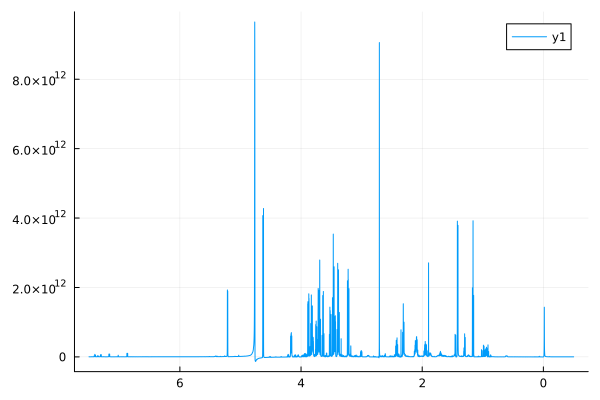

In [5]:
spect=NMR.FourierTransform(d,PPM=acqus["SFO1"],CTR=4.76,SI=65536) |> NMR.AutoPhaseCorrectChen |> x->NMR.cut(x,-0.5,7.5)
Plots.plot(spect,xaxis=:flip)

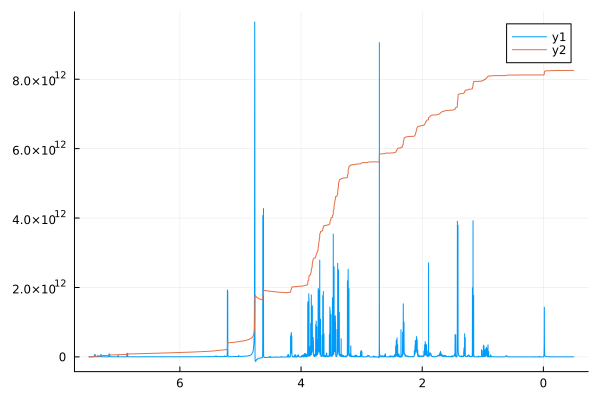

In [6]:
intSpect = NMR.integrate(spect,flip=true)
Plots.plot!(20*intSpect)

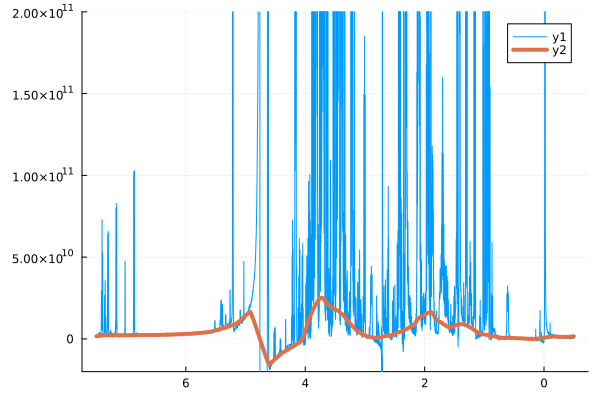

In [7]:
Plots.plot(spect,xaxis=:flip)
Plots.plot!(NMR.medianBaseline(real(spect),wdw=512),linewidth=4.0,ylims=2.0e10*[-1,10])

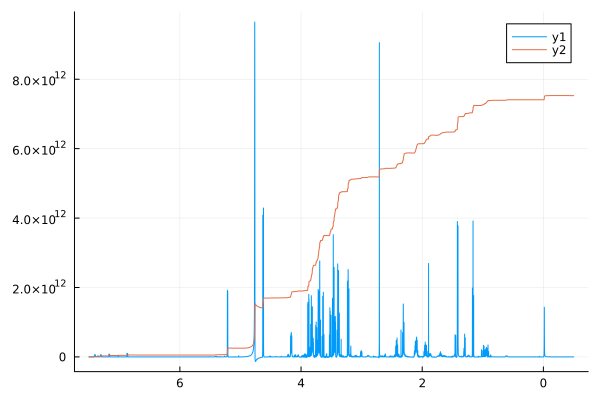

In [9]:
spectBc = real(spect)-NMR.medianBaseline(real(spect),wdw=512)
Plots.plot(spectBc,xaxis=:flip)
intSpect = NMR.integrate(spectBc,flip=true)
Plots.plot!(20*intSpect)

In [10]:
pks=NMR.peaks(spectBc,threshold=1e2)

NMR.PeakStruct([-0.015624494407330554, 0.5978339231827869, 0.609495606936842, 0.6215153853006578, 0.8704660845257212, 0.9034687643520617, 0.9140414859211186, 0.9264708910802416, 0.9261974004343365, 0.937962893966496  …  7.017948232550505, 7.159779553775709, 7.171516469152962, 7.298891128445471, 7.3097346992218935, 7.308760213871688, 7.351574033104208, 7.393682025528287, 7.40418883848688, 7.414654349142647], [1.1757808447654622e12, 2.6202725029048172e10, 3.089584779125648e10, 2.590727148278834e10, 3.1905540369818447e10, 9.477119799288704e10, 2.03017632857027e11, 1.9689952244039386e11, 2.0299464350630606e11, 2.357036978822802e11  …  4.2314037956868e10, 5.950555434903163e10, 5.754677117970999e10, 5.829468280261982e10, 5.580024841426606e10, 5.65539992418323e10, 2.6290018115308678e10, 4.0084050853093025e10, 5.406774478494613e10, 2.1149354446722057e10], [1.4870047205325536e17, 1.419598160241561e15, 7.383584546848532e14, 1.4869419390587905e15, 5.594730833459354e15, 1.62144019449643e16, 3.5364

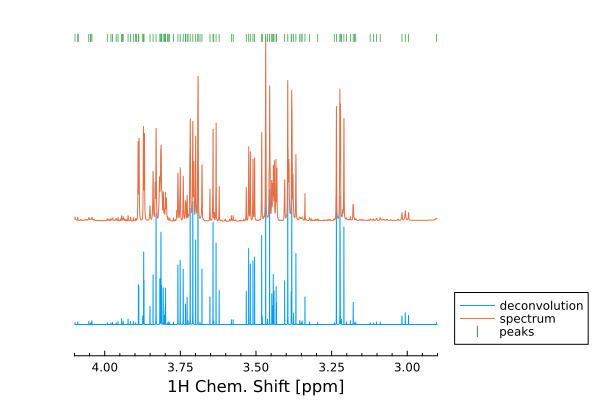

In [11]:
Plots.plot(pks.deconvolution,xaxis=:flip,xlims=[2.9,4.1],ylims=6.0e11*[-1,10],label="deconvolution",yaxis=false,grid=false,legend=Symbol(:outer,:bottomright),minorticks=true,xlabel="1H Chem. Shift [ppm]")
Plots.plot!(spectBc+2.0e12,label="spectrum") 
Plots.plot!(pks.positions,5.5e12*ones(length(pks.positions)),seriestype=:scatter,marker=:vline,label="peaks")

In [117]:
Symbol(:outer,:bottomright)

:outerbottomright

## Experiments for NMR Data Structure

The NMR data structure should be
- able to hold NMR data of any number of dimensions
- allow efficient calculations
- be compatible with any style of numerical array, including sparse arrays
- cleanly interface with `LinearAlgebra`, `DataFrames`, `CUDA`, and `Flux` packages
- allow integer indexing (like a matrix) to access indvidual data points
- provide a mechanism for conversion of indices to and from axes


In [7]:
struct TestArray{T,N} <: AbstractArray{T,N}
    dat::AbstractArray{T,N}
    params::Dict{Symbol,Any}
    ind

    function TestArray(A::AbstractArray{T,N},p::Dict{Symbol,<:Any},indx::Vararg{Any,N}) where {T,N}
        return new{T,N}(A,p,indx)
    end
end

Base.size(A::TestArray{T,N}) where {T,N}  = size(A.dat)
Base.getindex(A::TestArray{T,N},i::Integer) where {T,N} = getindex(A.dat,i)
Base.getindex(A::TestArray{T,N},r::Real) where {T,N} = getindex(A.dat,convert(Int64,round(r)))
Base.IndexStyle(A::TestArray{T,N}) where {T,N} = IndexStyle(A.dat)

Base.getindex(A::TestArray,S::Symbol) = A.params[S]

function Base.show(io::IO,fmt::MIME,A::TestArray{T,N} where {T,N})
    show(io, fmt, A.dat)
    show(io,fmt,A.params)
end

function Base.display(A::TestArray{T,N} ) where {T,N}
    display("TestArray{$T,$N}")
    display(A.dat)
    display(A.params)
end

import Base.+
+(A::TestArray{T,N},B::TestArray{T2,N2}) where {T,N,T2,N2} = TestArray(A.dat+B.dat,merge(A.params,B.params),A.ind...)
+(A::TestArray{T,N},B::AbstractArray{T2,N2}) where {T,N,T2,N2} = TestArray(A.dat+B,A.params,A.ind...)
+(B::AbstractArray{T2,N2},A::TestArray{T,N}) where {T,N,T2,N2} = TestArray(A.dat+B,A.params,A.ind...)

+ (generic function with 192 methods)

In [9]:
A = TestArray([1 2 3 ; 4 5 6],Dict(:hello=>"Greetings"),[199,250],[3,4])
B = TestArray([1 2 3 ; 4 5 6],Dict(:bye=>"So long"),0:0.1:50,0:0.1:50)

"TestArray{Int64,2}"

2×3 Matrix{Int64}:
 1  2  3
 4  5  6

Dict{Symbol, Any} with 1 entry:
  :bye => "So long"

In [10]:
A+B

"TestArray{Int64,2}"

2×3 Matrix{Int64}:
 2   4   6
 8  10  12

Dict{Symbol, Any} with 2 entries:
  :hello => "Greetings"
  :bye   => "So long"

In [12]:
A+rand(2,3)+B

"TestArray{Float64,2}"

2×3 Matrix{Float64}:
 2.92629   4.31924   6.05831
 8.94382  10.8192   12.3402

Dict{Symbol, Any} with 2 entries:
  :hello => "Greetings"
  :bye   => "So long"

In [17]:
C=TestArray(rand(1024,1024),Dict(:hello=>"Greetings"),[199,250],[3,4])

"TestArray{Float64,2}"

1024×1024 Matrix{Float64}:
 0.617487  0.0534548  0.196125   …  0.056848   0.915044   0.828065
 0.745327  0.914597   0.519566      0.103256   0.574136   0.149113
 0.187344  0.882724   0.101757      0.959558   0.0818898  0.852679
 0.421369  0.801727   0.315469      0.811443   0.463269   0.242809
 0.862271  0.891895   0.427018      0.682896   0.941211   0.541877
 0.905445  0.109975   0.217988   …  0.378088   0.433377   0.10235
 0.152595  0.288287   0.78276       0.208223   0.966852   0.0477217
 0.780823  0.0240768  0.524025      0.845949   0.222053   0.61977
 0.279727  0.965487   0.659386      0.721366   0.233344   0.614063
 0.562003  0.755115   0.535196      0.0439126  0.332208   0.881863
 ⋮                               ⋱                        
 0.863841  0.829442   0.207541   …  0.439761   0.246777   0.999528
 0.421003  0.674879   0.401661      0.459972   0.517184   0.874024
 0.286332  0.71219    0.0878373     0.754585   0.440055   0.00678186
 0.941608  0.203614   0.28658       0.1179

Dict{Symbol, Any} with 1 entry:
  :hello => "Greetings"

In [28]:
@show sum(C,dims=2)
@show axes(C,1)
@show C[:hello]

sum(C, dims = 2) = [496.9626509936349; 517.419903009128; 510.71182072978803; 527.1083858493173; 496.9701021452054; 507.8521290451718; 505.2331258674367; 500.0300122081806; 515.547553251945; 509.58394154020135; 513.173787577979; 510.7599732486754; 502.4418794037503; 509.63273426955794; 501.2644989552883; 527.2179400303976; 505.0761314073138; 510.697755346972; 512.4330219622518; 498.1780955256764; 518.4692978858506; 518.7930076695712; 501.8570341919078; 514.7208307355253; 504.7875016149751; 514.6337746879632; 510.59665823836457; 512.3748911088069; 509.7364107307355; 504.80622160671834; 518.4090656875222; 518.8329608320043; 504.3373451160254; 511.1958022035947; 507.4526535857067; 526.9880949885635; 516.4745264131493; 514.0797555599811; 510.68251485056413; 516.7548690121497; 508.7790806932024; 509.25603032221176; 522.1419503669717; 511.883525339307; 522.8209297721329; 515.0208097837544; 500.3343186461908; 514.471559622883; 508.42119274768237; 521.6532542895603; 513.1224694055971; 514.17859

"Greetings"

In [16]:
A[1.5,0.3]

ArgumentError: ArgumentError: invalid index: 1.5 of type Float64

In [6]:
view(A,:,1)

2-element view(::TestArray{Int64, 2}, :, 1) with eltype Int64:
 1
 4

In [28]:
A+B

"TestArray{Int64,2}"

2×3 Matrix{Int64}:
 2   4   6
 8  10  12

Dict{Symbol, Any} with 1 entry:
  :hello => "Greetings"

In [29]:
A+[4 5 5 ; 7 -8 9]

"TestArray{Int64,2}"

2×3 Matrix{Int64}:
  5   7   8
 11  -3  15

Dict{Symbol, Any} with 1 entry:
  :hello => "Greetings"

In [2]:
[4 5 5; 7 -9 9]+A

UndefVarError: UndefVarError: `A` not defined

## CUDA

It is straightforward to convert such data objects into CuArrays:

In [31]:
using CUDA
Acu=CuArray(A)

2×3 CuArray{Int64, 2, CUDA.DeviceMemory}:
 1  2  3
 4  5  6

In [32]:
display(A)

"TestArray{Int64,2}"

2×3 Matrix{Int64}:
 1  2  3
 4  5  6

Dict{Symbol, Any} with 1 entry:
  :hello => "Greetings"

However, using CuArrays in TestArrays is also possible. 

In [41]:
cA = TestArray(CuArray(Float32.([3.4 55 ; 44 33])),Dict(:param=>"Hello"),0:0.1:50,0:0.1:50)

"TestArray{Float32,2}"

2×2 CuArray{Float32, 2, CUDA.DeviceMemory}:
  3.4  55.0
 44.0  33.0

Dict{Symbol, Any} with 1 entry:
  :param => "Hello"

In [13]:
A+cA

UndefVarError: UndefVarError: `A` not defined

## Sparse Arrays

In [14]:
using SparseArrays
sA=sparse(A)

UndefVarError: UndefVarError: `A` not defined

In [15]:
sA=TestArray{Float64,2}(sA,Dict(:hello=>"bingo"))

UndefVarError: UndefVarError: `sA` not defined

In [16]:
sA+B

UndefVarError: UndefVarError: `sA` not defined

In [17]:
achse=0.5:0.01:1.0

0.5:0.01:1.0

In [18]:
achse[47]

0.96

## Index and Axis conversion

In [19]:
function index(R::AbstractRange,x::Real)
    ix=divrem(x-first(R),step(R))
    return (1+floor(Int,ix[1]),ix[2]/step(R))
end

index (generic function with 1 method)

In [20]:
@time i,r=index(0.1:0.1:4,0.24)

  0.000004 seconds (2 allocations: 32 bytes)


(2, 0.3999999999999998)

## Saving and Loading using JLD2

In [2]:
import JLD2

In [7]:
A

"TestArray{Int64,2}"

2×3 Matrix{Int64}:
 1  2  3
 4  5  6

Dict{Symbol, Any} with 1 entry:
  :hello => "Greetings"

In [14]:
JLD2.jldsave("test.jld";A.dat,A.params)

In [15]:
JLD2.load("test.jld")

Dict{String, Any} with 2 entries:
  "dat"    => [1 2 3; 4 5 6]
  "params" => Dict{Symbol, Any}(:hello=>"Greetings")

In [16]:
sin(5)

-0.9589242746631385

In [17]:
sin(6.5
)

0.21511998808781552

In [1]:
using Plots; pgfplotsx()
pl  = plot(1:5)
pl2 = plot((1:5).^2, tex_output_standalone = true)
savefig(pl,  "myline.tikz")    # produces a tikzpicture environment that can be included in other documents
savefig(pl2, "myparabola.tex") # produces a standalone document that compiles by itself including preamble


ArgumentError: ArgumentError: Package PGFPlotsX not found in current path.
- Run `import Pkg; Pkg.add("PGFPlotsX")` to install the PGFPlotsX package.

In [5]:
A=rand(49,49)

49×49 Matrix{Float64}:
 0.432392    0.512587    0.854304   …  0.9559     0.624977    0.660631
 0.908059    0.00217504  0.618158      0.401742   0.552087    0.668747
 0.576486    0.502374    0.399415      0.790462   0.622368    0.917839
 0.0819557   0.648681    0.769413      0.464256   0.0969592   0.272312
 0.274475    0.83856     0.28876       0.738306   0.431878    0.795115
 0.682527    0.385502    0.558483   …  0.529406   0.430712    0.5701
 0.906751    0.0338851   0.145735      0.225297   0.45337     0.641761
 0.964283    0.690771    0.756605      0.925591   0.98319     0.700671
 0.161974    0.578924    0.898526      0.208447   0.628071    0.382391
 0.620196    0.674744    0.02471       0.0179728  0.857483    0.853423
 ⋮                                  ⋱                         
 0.00953848  0.999351    0.12256    …  0.821077   0.390233    0.702586
 0.235078    0.2359      0.0928635     0.664521   0.411864    0.702799
 0.0348534   0.236064    0.5292        0.942248   0.00529453  0.

In [6]:
size(A)

(49, 49)

In [10]:
axes(A,1)

Base.OneTo(49)

In [4]:
struct SpectData{T,N} <: AbstractArray{T,N}
    dat::AbstractArray{T,N}
    coord::NTuple{N,AbstractVector}
end

import Base.size
import Base.getindex
import Base.IndexStyle

size(S::SpectData) = size(S.dat)
getindex(S::SpectData, k::Integer) = getindex(S.dat,k)
IndexStyle(S::SpectData) = IndexStyle(S.dat)

IndexStyle

In [5]:
s=SpectData(rand(2,34),(["hallo","bongo"],Base.range(0.1,10,length=34)))

2×34 SpectData{Float64, 2}:
 0.121399  0.760195  0.10428   0.514537   …  0.249332   0.351203  0.719341
 0.423485  0.689027  0.276456  0.0433743     0.0461534  0.291264  0.798357

In [6]:
s*rand(34,2)

2×2 Matrix{Float64}:
  8.7865  7.62737
 10.0366  8.98156

UndefVarError: UndefVarError: `s` not defined

In [34]:
s=SpectData(rand(2,34),(Dict("hallo"=>1,"bongo"=>2),Base.range(0.1,10,length=34)))

MethodError: MethodError: no method matching SpectData(::Matrix{Float64}, ::Tuple{Dict{String, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}})

Closest candidates are:
  SpectData(::AbstractArray{T, N}, !Matched::Tuple{Vararg{AbstractVector, N}}) where {T, N}
   @ Main ~/Source/NMR.jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X65sdnNjb2RlLXJlbW90ZQ==.jl:2


In [13]:
DEPOT_PATH

3-element Vector{String}:
 "/home/mu3q/.julia"
 "/opt/julia-1.10.1/local/share/julia"
 "/opt/julia-1.10.1/share/julia"

In [14]:
LOAD_PATH

3-element Vector{String}:
 "@"
 "@v#.#"
 "@stdlib"

In [15]:
PROJECT

UndefVarError: UndefVarError: `PROJECT` not defined